# 그래프 데이터 로드하고 처리하기

이 세션에서, 여러분은 다음을 익힐 수 있습니다.

* CSV 파일로 저장된 그래프 데이터를 로드하는 방법

* DGL로 그래프를 구축하는 방법

* DGL 그래프의 구조적인 정보에 대해 조회

* 노드와 엣지 피처를 적재하고 전처리하는 방법

* 메시지 패싱(message passing)에 피처 할당


## CSV에서 그래프 데이터 호출하기

CSV는 관계형 데이터 저장에 널리 사용되는 포맷입니다. 이 튜토리얼에서, Zachery의 Karate 클럽 네트워크 데이터를 포함한 2개의 csv 파일을 준비했습니다. 
[the Zachery's Karate Club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

* `nodes.csv`는 클럽 멤버와 그들의 특징을 포함하고 있습니다.
* `edges.csv`는 두 클럽 멤버간의 쌍별 상호작용을 포함하고 있습니다.

In [5]:
!ls -lh '../data'

total 12K
-rw-r--r-- 1 root root 3.8K Feb 17 06:53 edges.csv
-rw-r--r-- 1 root root 1.3K Feb 17 06:53 gen_data.py
-rw-r--r-- 1 root root  461 Feb 17 06:53 nodes.csv


`pandas` 라이브러리를 사용해 csv 파일을 로드할 수 있습니다.

In [6]:
import pandas as pd

nodes_data = pd.read_csv('../data/nodes.csv')
print(nodes_data)

    Id     Club  Age
0    0   Mr. Hi   45
1    1   Mr. Hi   33
2    2   Mr. Hi   36
3    3   Mr. Hi   31
4    4   Mr. Hi   41
5    5   Mr. Hi   42
6    6   Mr. Hi   48
7    7   Mr. Hi   41
8    8   Mr. Hi   30
9    9  Officer   35
10  10   Mr. Hi   38
11  11   Mr. Hi   44
12  12   Mr. Hi   37
13  13   Mr. Hi   39
14  14  Officer   36
15  15  Officer   38
16  16   Mr. Hi   47
17  17   Mr. Hi   45
18  18  Officer   41
19  19   Mr. Hi   31
20  20  Officer   31
21  21   Mr. Hi   44
22  22  Officer   42
23  23  Officer   32
24  24  Officer   30
25  25  Officer   50
26  26  Officer   30
27  27  Officer   43
28  28  Officer   48
29  29  Officer   40
30  30  Officer   39
31  31  Officer   45
32  32  Officer   47
33  33  Officer   33


In [7]:
edges_data = pd.read_csv('../data/edges.csv')
print(edges_data)

     Src  Dst    Weight
0      0    1  0.318451
1      0    2  0.551215
2      0    3  0.227416
3      0    4  0.266919
4      0    5  0.475449
..   ...  ...       ...
151   33   28  0.266479
152   33   29  0.279901
153   33   30  0.652154
154   33   31  0.828536
155   33   32  0.842656

[156 rows x 3 columns]


그 뒤 각 노드는 클럽 멤버를 나타내고 각 엣지는 그들의 상호작용을 나타내는 그래프를 만듭니다. DGL에서, 노드는 0부터 시작하는 연속적인 정수입니다.
그러므로, 데이터를 준비할 때, 라벨을 다시 매기거나 행 순서를 다시 셔플하는 작업이 중요합니다. 이로써 첫번째 행이 첫번째 노드에 상응하도록하고, 그 뒤도 마찬가지로 매칭되도록 해줍니다.

이 예시에서는, 올바른 순서로 데이터가 준비되어 있습니다. 따라서 `edges.csv` 테이블의 `'Src'`와 `'Dst'` 칼럼으로 그래프를 만들 수 있습니다.

In [8]:
import dgl

src = edges_data['Src'].to_numpy()
dst = edges_data['Dst'].to_numpy()

Using backend: pytorch


In [9]:
src

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12,
       12, 13, 13, 13, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19,
       19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25,
       25, 25, 26, 26, 27, 27, 27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30,
       30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33])

In [10]:
dst

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,
        2,  3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28,
       32,  0,  1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5,
       16,  0,  1,  2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4,  5,  0,  0,
        3,  0,  1,  2,  3, 33, 32, 33, 32, 33,  5,  6,  0,  1, 32, 33,  0,
        1, 33, 32, 33,  0,  1, 32, 33, 25, 27, 29, 32, 33, 25, 27, 31, 23,
       24, 31, 29, 33,  2, 23, 24, 33,  2, 31, 33, 23, 26, 32, 33,  1,  8,
       32, 33,  0, 24, 25, 28, 32, 33,  2,  8, 14, 15, 18, 20, 22, 23, 29,
       30, 31, 33,  8,  9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29,
       30, 31, 32])

In [11]:
# 한쌍의 넘파이 배열로부터 DGL 그래프를 생성
g = dgl.graph((src, dst))

In [12]:
# 그래프를 출력하면, 노드와 엣지 숫자 등의 메타 정보를 보여줍니다.
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={}
      edata_schemes={})


DGL 그래프는 시각화와 같은 풍부한 기능을 사용할 수 있도록 `networkx` 그래프로 변환시킬 수 있습니다.

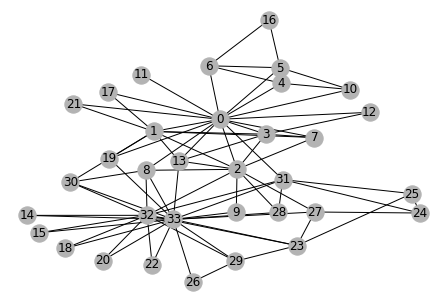

In [13]:
import networkx as nx
# 그래프가 무방향성이므로, 시각화 목적을 위해 변형했습니다.

nx_g = g.to_networkx().to_undirected()
# kamada-kawaii 레이아웃은 임의의 그래프에 대해 보기 좋은 형태를 제공합니다

pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, node_color=[[.7, .7, .7]])

## 그래프 구조에 대해 쿼리 날리기

얼마나 많은 노드와 엣지가 그래프 내에 있는지 확인해 봅시다.

In [14]:
print('#Nodes', g.number_of_nodes())
print('#Edges', g.number_of_edges())

#Nodes 34
#Edges 156


그래프 구조에 대한 쿼리도 수행해 볼 수 있습니다.

노드 0의 in-degree(유입 차수)는 얼마일까요?

In [15]:
g.in_degree(0)

/opt/conda/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.in_degree is deprecated. Please use DGLGraph.in_degrees
  return warnings.warn(message, category=category, stacklevel=1)


16

노드 0의 successors(연결된 노드들)는 어떤 노드들일까요?

In [16]:
g.successors(0)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31])

DGL은 그래프의 구조적 정보에 대해 쿼리를 날릴 수 있는 기능에 대한 API를 제공합니다.   
API 도큐먼트를 확인해 주세요! [여기에서!](https://docs.dgl.ai/api/python/heterograph.html#querying-graph-structure)

![image.png](../asset/dgl-query.png)

## Load node and edge features

많은 그래프 데이터에서, 노드와 엣지는 특성(attributes)을 가지고 있습니다. 
이 특성들이 임의의 타입을 가질지라도, DGL 그래프는 텐서의 형태로 저장된 특성만을 받아들입니다(수치적 정보를 포함한 텐서). 
딥러닝에서의 비약적인 발달은 다양한 타입의 특성을 수치형 피처로 만들어 벡터화할 많은 방법을 제시했습니다.   

아래는 몇가지 일반적인 제안입니다: 

* 범주형 특성에 대해서는 (예를 들어 성별, 직업 등), 정수 혹은 one-hot encoding으로 바꾸는 것을 고려할 것  
* 문자열 컨텐츠(가령 뉴스 기사, 인용문 등)의 경우 언어 모델을 적용하는 것을 고려할 것
* 이미지에 대해서는, CNN과 같은 비전 모델을 적용할 것을 고려할 것  

우리의 데이터 셋에는 다음 특성이 포함되어 있습니다:

* `Age` 는 이미 정수형 특성입니다.
* `Club` 은 범주형 특성으로 각 멤버가 어떤 커뮤니티에 속해있는지를 나타냅니다..
* `Weight` 는 부동 소수점 수치형 데이터로 각 관계의 강도를 나타냅니다.

In [17]:
import torch
import torch.nn.functional as F

# '나이' 노드 피처를 준비합니다
age = torch.tensor(nodes_data['Age'].to_numpy()).float() / 100
print(age)

tensor([0.4500, 0.3300, 0.3600, 0.3100, 0.4100, 0.4200, 0.4800, 0.4100, 0.3000,
        0.3500, 0.3800, 0.4400, 0.3700, 0.3900, 0.3600, 0.3800, 0.4700, 0.4500,
        0.4100, 0.3100, 0.3100, 0.4400, 0.4200, 0.3200, 0.3000, 0.5000, 0.3000,
        0.4300, 0.4800, 0.4000, 0.3900, 0.4500, 0.4700, 0.3300])


In [18]:
# 노드 0~10까지의 피처 조회
age[[0, 10]]

tensor([0.4500, 0.3800])

`g.ndata`를 사용해 그래프의 age feature를 설정

In [19]:
# 피처를 그래프에 입력함
g.ndata['age'] = age
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'age': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})


In [20]:
# "Club" 칼럼은 각 노드가 어떤 커뮤니티에 포함되어 있는지를 나타냅니다
# 입력 값은 스트링 타입으로, 범주형 정수 값 혹은 원핫 인코딩 값으로 바꾸어 주어야 합니다

club = nodes_data['Club'].to_list()

In [21]:
# 범주형 정수 값으로 바꿔줍니다. 'Mr. Hi'는 0으로, 'Officer'는 1로.

club = torch.tensor([c == 'Officer' for c in club]).long()

In [22]:
# 원핫 인코딩으로 변환할수도 있습니다.
club_onehot = F.one_hot(club)
print(club_onehot)

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]])


In [23]:
# `g.ndata`는 일반적인 딕셔너리처럼 사용하세요
g.ndata.update({'club' : club, 'club_onehot' : club_onehot})

# del을 사용해 몇몇 피처를 제거할 수 있습니다
del g.ndata['age']

print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


엣지 피처를 DGL 그래프에 입력해 주는 것도 비슷합니다.

In [24]:
# 데이터프레임에서 엣지 피처를 가져와 그래프에 입력해 줍니다.
edge_weight = torch.tensor(edges_data['Weight'].to_numpy())

# 앞에서 노드의 경우와 비슷하게, `g.edata`를 사용해 엣지 피처를 가져오고/입력해줄 수 있습니다.
g.edata['weight'] = edge_weight
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


In [25]:
# 무작위의 4d 피처를 srcdata에 할당하고, dstdata에는 7d 피처를 할당해 줍니다
g.srcdata['src_h'] = torch.randn(34,4)
g.dstdata['dst_h'] = torch.randn(34,7)

print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64), 'src_h': Scheme(shape=(4,), dtype=torch.float32), 'dst_h': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


그래프 `g`에서는, 두 노드 피처가 ndata_schema에 저장되어 있습니다. 이 두 피처에 대해 `ndata`를 사용해 직접적으로 쿼리를 날릴 수 있습니다.

In [26]:
print(g.ndata['src_h'])

tensor([[ 1.1459, -1.3841, -2.5142, -0.0706],
        [-2.2275,  0.1928, -0.3601, -0.9445],
        [ 0.1504,  0.0946,  0.4751,  0.9307],
        [ 1.3632, -0.4057,  0.8035,  0.0418],
        [ 2.9016,  0.5482,  0.1361, -0.4469],
        [ 0.4492,  1.1089,  0.1847, -2.4281],
        [ 0.4810, -1.4071,  0.6524,  1.2818],
        [ 0.8271, -0.1786, -0.1237, -0.6307],
        [ 0.7777, -1.5889, -0.8333,  1.8343],
        [-1.0323, -0.8772, -1.8890, -2.5269],
        [-0.2843, -1.5697,  0.1793, -0.2243],
        [ 0.4193,  1.1821,  1.2831, -0.0559],
        [-1.3623,  0.2333,  2.1299, -0.5955],
        [ 1.5706,  0.6627, -0.1184,  0.7760],
        [-0.8508,  0.0773,  0.2400,  1.1195],
        [ 1.0124,  1.1583, -2.3286,  1.6014],
        [ 0.8000, -0.8671,  0.2114, -1.6082],
        [-0.3231, -1.8233,  1.3770,  0.2846],
        [-0.6978,  0.7989,  0.5712,  2.0088],
        [ 0.9127, -1.3314, -0.3144,  2.0080],
        [ 0.0739,  1.7060,  0.5414, -0.7025],
        [-0.8056, -1.1041, -1.8635